# Acute myeloid leukemia mouse model heatmap
_Author: Candace Savonen adapted this analysis based on this [R refine.bio-examples notebook](https://alexslemonade.github.io/refinebio-examples/03-rnaseq/clustering_rnaseq_01_heatmap.html)_   
_Date: October 2021_  

## Purpose of the analysis

In this analysis, we will use this [acute myeloid leukemia sample dataset](https://www.refine.bio/experiments/SRP070849) from [Shih et al, 2017](https://pubmed.ncbi.nlm.nih.gov/28193779/) and pre-processed by [refinebio](https://www.refine.bio/).

The data that we downloaded from [refine.bio](https://www.refine.bio/) for this analysis has 19 samples (obtained from 19 acute myeloid leukemia (AML) model mice), containing RNA-sequencing results for types of AML under controlled treatment conditions.

This [dataset can be downloaded from this page on refine.bio](https://www.refine.bio/experiments/SRP070849). 
We will download it already [processed and quantile normalized](http://docs.refine.bio/en/latest/main_text.html#refine-bio-processed-refinebio-processedibadge). 

## Import libraries

In [1]:
# We need this for creating directories
import os
from pathlib import Path

# For session info
import session_info

# We need this for downloading data from refine.bio
import pyrefinebio

# We will use these for manipulating our data
import pandas as pd
import numpy as np
import random

# We will use this for making the heatmap and these for the color codes
import seaborn as sns

sns.set_theme(color_codes=True)

# Import custom color key function
import util.color_key as color_key

import matplotlib.pyplot as plt

Set the seed

In [2]:
random.seed(1234)

## Set up analysis folders

In [3]:
dirnames = ["data", "results", "plots"]

# Create the directory if it doesn't exist
for dirname in dirnames:
    if not os.path.isdir(dirname):
        os.mkdir(dirname)

This notebook will be downloading the data for the project ID 'SRP070849' from refine.bio. 
By switching the line below, the rest of the notebook where the the experiment ID is referenced will be updated. 

In [4]:
# Declare project ID
id = "SRP070849"

In [5]:
# Define the file path to the data directory
data_dir = Path(f"data/{id}")

# Declare the file path to the gene expression matrix file
data_file = data_dir.joinpath(f"{id}.tsv")

# Declare the file path to the metadata file
# inside the directory saved as `data_dir`
metadata_file = data_dir.joinpath(f"metadata_{id}.tsv")

## Import and set up data

First we will download our dataset from refine.bio using their API client. But we will only download if the files don't already exist locally.  

In [6]:
if not data_file.exists() or not metadata_file.exists():

    print(f"Downloading {id} from refine.bio")

    pyrefinebio.create_token(agree_to_terms=True, save_token=False)

    pyrefinebio.download_dataset(
        data_dir.joinpath("dataset.zip"),
        "cansav09@gmail.com",
        experiments=[f"{id}"],
        extract=True,
    )

Now we can read in our expression data and metadata with `pandas`. 

In [7]:
# Read in metadata TSV file
metadata = pd.read_csv(metadata_file, sep="\t")

In [8]:
# Read in data TSV file
expression_df = pd.read_csv(data_file, sep="\t")

For our seaborn heatmap, we will what our gene IDs to be set as the index of our data frame. 

In [9]:
# Set the Gene column as the index
expression_df.set_index("Gene", inplace=True)

Let's take a look at the metadata object that we read into the R environment.

In [10]:
metadata.head(5)

,refinebio_accession_code,experiment_accession,refinebio_age,refinebio_cell_line,refinebio_compound,refinebio_disease,refinebio_disease_stage,refinebio_genetic_information,refinebio_organism,refinebio_platform,...,refinebio_processor_version,refinebio_race,refinebio_sex,refinebio_source_archive_url,refinebio_source_database,refinebio_specimen_part,refinebio_subject,refinebio_time,refinebio_title,refinebio_treatment
0,SRR3189679,SRP070849,NaN,NaN,NaN,NaN,NaN,NaN,MUS_MUSCULUS,Illumina HiSeq 2000 (IlluminaHiSeq2000),...,v1.25.6-hotfix,NaN,NaN,NaN,SRA,lin-sca+ckit+,hematopoietic stem cells,NaN,WT-1 RNA-Seq,none
1,SRR3189680,SRP070849,NaN,NaN,NaN,NaN,NaN,NaN,MUS_MUSCULUS,Illumina HiSeq 2000 (IlluminaHiSeq2000),...,v1.25.6-hotfix,NaN,NaN,NaN,SRA,lin-sca+ckit+,hematopoietic stem cells,NaN,WT-2 RNA-Seq,none
2,SRR3189681,SRP070849,NaN,NaN,NaN,NaN,NaN,NaN,MUS_MUSCULUS,Illumina HiSeq 2000 (IlluminaHiSeq2000),...,v1.25.6-hotfix,NaN,NaN,NaN,SRA,lin-sca+ckit+,hematopoietic stem cells,NaN,WT-3 RNA-Seq,none
3,SRR3189682,SRP070849,NaN,NaN,NaN,NaN,NaN,NaN,MUS_MUSCULUS,Illumina HiSeq 2000 (IlluminaHiSeq2000),...,v1.25.6-hotfix,NaN,NaN,NaN,SRA,lin-sca+ckit+,hematopoietic stem cells,NaN,WT-4 RNA-Seq,none
4,SRR3189683,SRP070849,NaN,NaN,NaN,NaN,NaN,NaN,MUS_MUSCULUS,Illumina HiSeq 2000 (IlluminaHiSeq2000),...,v1.25.6-hotfix,NaN,NaN,NaN,SRA,lin-sca+ckit+,hematopoietic stem cells,NaN,IDH2.FLT3_veh_1 RNA-Seq,vehicle


Now let's ensure that the metadata and data are in the same sample order.

In [11]:
print(metadata["refinebio_accession_code"].tolist() == expression_df.columns.tolist())

True


## Choose genes of interest

For this example, we will sort genes by variance and select genes in the upper quartile, but there are many alternative criterion by which you may want to sort your genes, <i>e.g.</i> fold change, t-statistic, membership in a particular gene ontology, so on.

In [12]:
# Calculate the variance for each gene
expression_df["variance"] = expression_df.var(axis=1, skipna=True)

# Find the upper quartile for these data
upper_quartile = expression_df["variance"].quantile([0.90]).values

# Filter the data choosing only genes whose variances are in the upper quartile
df_by_var = expression_df[expression_df.variance > float(upper_quartile)]

# Drop the variance column we calculated
df_by_var = df_by_var.drop(columns="variance")

In [13]:
# Check how many genes we are left with
print(len(df_by_var.index))

4125


### Write top variance genes to a TSV file

In [14]:
# Write df_by_var to tsv file
df_by_var.to_csv("results/top_90_var_genes.tsv", sep="\t")

## Prepare metadata for annotation

From the accompanying [paper](https://pubmed.ncbi.nlm.nih.gov/28193779/), we know that the mice with `IDH2` mutant AML were treated with vehicle or AG-221 (the first small molecule in-vivo inhibitor of IDH2 to enter clinical trials) and the mice with `TET2` mutant AML were treated with vehicle or 5-Azacytidine (Decitabine, hypomethylating agent). [@Shih2017]

In [15]:
# Recode refinebio_title variable into something more useful
# Split wherever there is a '-' or '.'
exp_group = metadata["refinebio_title"].str.split("-|\\.", expand=True, n=1)

In [16]:
# Now we'll store that first column from the string split back in the metadata as a column
metadata["exp_group"] = exp_group[0]

In [17]:
# Print to check
print(metadata["exp_group"])

0       WT
1       WT
2       WT
3       WT
4     IDH2
5     IDH2
6     IDH2
7     IDH2
8     IDH2
9     IDH2
10    IDH2
11    TET2
12    TET2
13    TET2
14    TET2
15    TET2
16    TET2
17    TET2
18    TET2
Name: exp_group, dtype: object


In [18]:
# Color code our two variables
refinebio_treatment_colors = color_key.make_color_key(metadata["refinebio_treatment"])
exp_groups_colors = color_key.make_color_key(metadata["exp_group"])

Make them into one data frame we can provide to the heatmap for annotation. 

In [19]:
color_key_df = pd.concat(
    [refinebio_treatment_colors["color_key"], exp_groups_colors["color_key"]],
    axis=1,
    names=["treatment", "exp_group"],
)

color_key_df = color_key_df.set_index(df_by_var.columns)

Print out our annotation data frame to make sure it looks right. 

In [20]:
# Check that this is what we think it is
color_key_df

,refinebio_treatment,exp_group
SRR3189679,#E30212,#221829
SRR3189680,#E30212,#221829
SRR3189681,#E30212,#221829
SRR3189682,#E30212,#221829
SRR3189683,#3B7000,#FB876E
SRR3189684,#3B7000,#FB876E
SRR3189685,#3B7000,#FB876E
SRR3189686,#BFE425,#FB876E
SRR3189687,#BFE425,#FB876E
SRR3189688,#BFE425,#FB876E


# Create and store the annotated heatmap object

/opt/conda/envs/reproducible-python/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


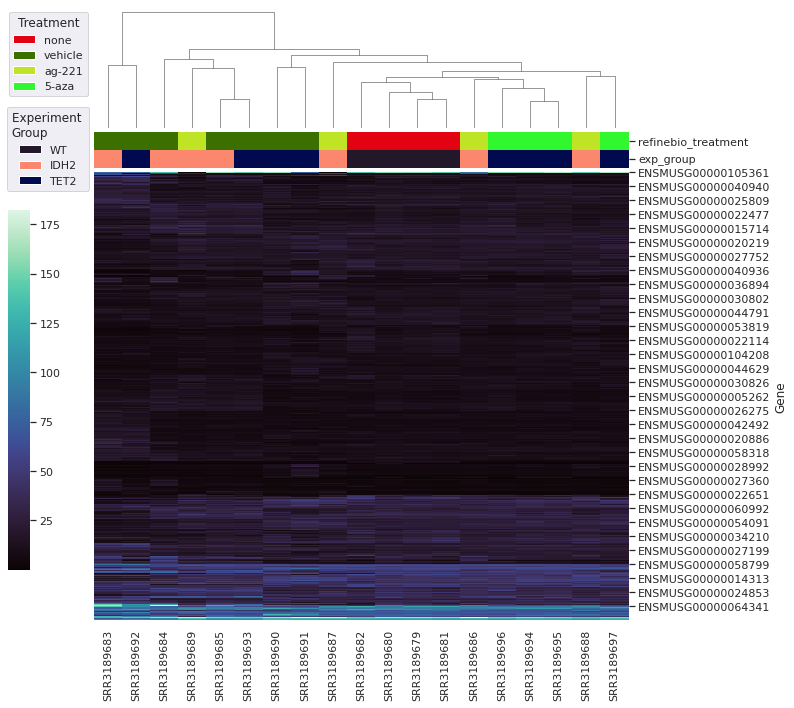

In [21]:
heatmap = sns.clustermap(
    df_by_var,
    cmap="mako",
    col_colors=color_key_df,
    dendrogram_ratio=(0, 0.2),
    cbar_pos=(-0.1, 0.2, 0.03, 0.5),
)

legend1 = color_key.make_legend(exp_groups_colors["color_key_dict"])
legend2 = color_key.make_legend(refinebio_treatment_colors["color_key_dict"])

# Make a legend 1
plt.legend(
    legend1,
    exp_groups_colors["color_key_dict"],
    title="Experiment \nGroup",
    bbox_to_anchor=(4, 1.3),
)

# Make a legend 2
heatmap.ax_row_dendrogram.legend(
    legend2,
    refinebio_treatment_colors["color_key_dict"],
    title="Treatment",
    bbox_to_anchor=(0, 1.37),
)

plt.show()

Now we need to set up a legend for the color bar. 

In [22]:
# Save to png
heatmap.savefig(os.path.join("plots", "aml_heatmap.png"))

### Print out session info 

In [23]:
session_info.show()